In my previous notebooks, I have written several common machine learning algorithms from scratch: Decision Tree, Random Forest, and K-Nearest Neighbor. The accuracy of the models were sometimes lackluster - the KNN model was unable to reliabily classify images of cats and dogs correctly, for potential reasons I discussed in depth in the relevant notebook - but overall all of the models were able to make predictions of the class of a novel observation after being trained on a subset of the data.

All of these models were able to predict the class an input belonged to as the dataset they were trained on contained observations of the feature that was to be predicted. For instance, the KNN could predict whether an image was a dog or a cat as the dataset contained images that were labeled as being either cats or dogs. Without these observations, the models couldn't be applied to the datasets. To elaborate this further, imagine being given the task to classify images as being either "Xorbs" or "Fifis". You're given a thousand images, 500 of which are Xorbs and 500 of which are Fifis, and you're given some random picture that needs to be classified as a Xorb or a Fifi. But you're not told which example images you're given are Xorbs and which ones are Fifis. 

If Xorbs and Fifis look different, you might be able to assign the random picture to the appropriate group, but you wouldn't be able to confidently classify it without being told which label belonged to which group of images. 

While classifying observations is typically an example of Supervised Learning - Decision Trees, Random Forests, and KNNs are all Supervised Learning techniques - grouping observations typically involves using an Unsupervised Learning algorithm. These algorithms can be applied when labels for the observations do not exist, or when any labels for the dataset are irrelevant to the desired goal.

Datasets invoolving housing prices, such as this one, are typically used to train Superivsed Learning models such as a Linear Regression model that predicts the price of a house given a set of known features it has. Nevertheless, it might be the case that such a dataset doesn't contain the prices of homes, or that it does contain that information, but the goal isn't to predict the price of homes - as will be the case with the model built in this dataset.

Specifically, the goal of this notebook will be to build a model that identifies subsets of the observations that share similarities, or if such subsets exist. It may be the case that houses fall into two subsets - "normal" houses, and mansions. Or it may be the case that there are three general subsets of houses, geared for low, middle, and upper class households. Or maybe houses comprise an amorphous blob with no distinct subsets. 

To achieve this, a Unsupervised Learning model - K-Means Clustering - will be constructed and trained using just numpy and pandas. 

First, we'll take a look at some of the features of the dataset. 

In [ ]:
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

# First, a random seed will be used to make the notebook more deterministic.
# rs will be used in place of np.random to achieve this.
rs = RandomState(MT19937(SeedSequence(1085)))

df = pd.read_csv("/kaggle/input/housesalesprediction/kc_house_data.csv")
print("Observations: {}".format(len(df)))
print("Feature Count: {}".format(len(df.columns)))
print("Features: {}".format(list(df.columns)))
print("Unique Entries per Feature: {}".format([col + ": " + str(len(df[col].unique())) for col in df.columns]))

There are over 20,000 observations in the dataset, with each observation having 21 features. Of those features, only `waterfront` is a binary feature, and just three others - `floors`, `view`, and `condition` - have under ten unique values. 

From a brief analysis, the feature `id` seems to be safe to discard, the feature `zipcode` is the only nominal feature, `price`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `lat`, `long`, `sqft_living15`, and `sqft_lot15` are continuous features, and the remaining variables are oridinal categorical features. Thus, only `zipcode` and the binary value `waterfront` require being mapped to a one-hot encoding, which would increase the dimensionality of the dataset from 20 (with `id` removed) to 90, as `zipcode` has 70 unique values, and `waterfront` is a binary variable.

In [ ]:
# Save the original DF
original_df = df.copy()

# One-Hot Encoding
df = df.join(pd.get_dummies(df["zipcode"]))
df = df.join(pd.get_dummies(df["waterfront"]))
df = df.drop("zipcode", axis=1)
df = df.drop("waterfront", axis=1)

# Drop the `id` column
df = df.drop("id", axis=1)

# Format the `date` column
df["date"] = df["date"].apply(lambda date: date[:date.index("T")])
df["date"] = pd.to_datetime(df["date"]).astype(int)

# Convert all entries to float
df = df.astype(float)

print(df.head())

# Min-Max Normalization
df = (df - df.min())/(df.max() - df.min())

To get a partial visualization of the data, a scatterplot will be graphed using the number of bedrooms and bathrooms of the houses. The size of each data point will correspond to how many houses share those features, as it can be expected that there will be more houses in the dataset with 2 bedrooms and 2 bathrooms than there will be houses with 6 bedrooms and 4 bathrooms, so the data points should have different sizes.

In [ ]:
# Get the number of observations with the same number of bedrooms and bathrooms as the current example, and use that to set the point size 
size = [len(df[(df["bedrooms"] == bedrooms) & (df["bathrooms"] == bathrooms)]) for bedrooms, bathrooms in zip(df["bedrooms"], df["bathrooms"])]

plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 22})
plt.scatter(df["bedrooms"], df["bathrooms"], size)
plt.xlabel("Bedrooms")
plt.ylabel("Bathrooms")
plt.grid()
plt.show()

As expectations might suggest, the graph shows a positive correlation between the number of bedrooms and the number of bathrooms a house has, with a suprising outlier of a house with over 30 bedroooms and less than 2 bathrooms. 

There also aren't any obvious sub-clusters shown in the graph, apart from the one large cluster consiting of the entire dataset and then the small 30+ bedroom house that might warrant belonging to its own cluster. Of course, this is a 2-dimensional graph of 90-dimensional data, which completely drops 18 of the features in the dataset. More preciesely, a dataset which forms only one cluster when mapped onto a subset of its dimensions could still form multiple clusters when represented in all of its dimensions.

Since it'a not practical to graph 90 dimensional data without doing any dimensionality reduction (which is out of scope for this notebook, but is discussed in one of my past notebooks), the K-Means Clusters algorith will be implemented below to detect the existence of clusters in the dataset.

In [ ]:
class KMeansCluster:
    def __init__(self, k, debug=True):
        '''
        Initializes the KMeansCluster model
        
        :param k: The number of centroids to generate - thus, the number of clusters to form from the dataset.
        '''
        self.k = k
        self.points = []
        self.convergence_history = []
        self.debug = debug
        
    def load_points(self, df):
        '''
        Loads the DataFrame `df` into `self.points`.
        This method could easily be included as part of the constructor, but
        for clarity/readability, the initialization of `self.points` is done
        via this setter.
        '''
        self.df = df
        self.points = df.to_numpy()
        
        
    def init_centroids(self):
        '''
        Uses the Forgy Method to initialize the location of the centroids. The
        Forgy Method simply initializes the centroids by randomly selecting `k`
        points from the dataset without replacement, and setting the location of
        each centroid to one of the randomly selected points, such that each 
        centroid is assigned a unique point. However, if some of the randomly
        selected points share the same location, then the centroids would share
        the same initial location as well.
        '''
        self.centroids = self.points[rs.choice(self.points.shape[0], self.k, replace=False), :]
        
    def find_nearest_centroid(self, vector):
        '''
        Finds the nearest centroid for a given point `vector`. Distance
        is calcualted using Euclidean distance.
        
        :param vector: A datapoint to find the nearest centroid of.
        :returns: The index of the closest centroid in `self.centroids`
        '''
        min_dist = math.inf
        closest_centroid = -1
        for i, centroid in enumerate(self.centroids):
            distance = np.linalg.norm(vector - centroid)
            if distance < min_dist:
                min_dist = distance
                closest_centroid = i
        return closest_centroid
    
    def assign_nearest_centroids(self):
        '''
        Uses `self.find_nearest_centroid()` and returns a list of length
        len(self.points), where the ith element of the returned list
        denotes the index of the centroid in `self.centroids` that the 
        ith point in self.points is closest to.
        '''
        return [self.find_nearest_centroid(vector) for vector in self.points]
    
    def step(self):
        '''
        Performs a step of the K-Means Clustering algorithm by finding all
        of the nearest data points for each centroid, and then updating the
        location of the centroids to be the mean of all of the data points 
        to which they are the closest centroid.
        
        Returns a bool, denoting whether or not the step function resulted
        in the change of the position of any centroid or not.
        
        Raises an exception if the step function resulted in a cluster of
        size zero.
        '''
        centroid_indexes = self.assign_nearest_centroids()
        old_centroids = np.copy(self.centroids)
        for i, centroid in enumerate(self.centroids):
            closest_points = None
            for point_index, centroid_index in enumerate(centroid_indexes):
                if centroid_index == i:
                    closest_points = np.array([self.points[point_index]]) if closest_points is None else np.concatenate((closest_points, np.array([self.points[point_index]])))
            if closest_points is None:
                if self.debug:
                    print("One centroid has no nearest points after stepping. Breaking off stepping further.")
                raise Exception("Couldn't step due to at least one cluster not being assigned any nearest points.")
            self.centroids[i] = np.mean(closest_points, axis=0)
        self.convergence_history.append(np.linalg.norm(old_centroids - self.centroids))
        return not np.array_equal(old_centroids, self.centroids)
            
    def train(self):
        '''
        Trains the model by running the K-Means Clustering algorithm.
        
        Returns False if the clusters could not be fit due to at least one cluster not
        having any nearest points after training.
        '''
        step_num = 0
        print("Training the model...")
        try:
            while self.step():
                step_num += 1
                if self.debug:
                    print("Finished step {}".format(step_num))
                    print("Centroids moved {} in this step.".format(self.convergence_history[-1]))
        except:
            print("Couldn't train the model due to at least one centrid having no nearest points after step.")
            return False
        print("Model converged on a local optimum after {} steps".format(step_num))
        return True
        
    def get_clusters(self):
        '''
        Returns a list of length `len(self.centroids)`, where the ith
        element in the list corresponds to all of the points in the ith
        cluster.
        '''
        clusters = []
        centroid_indexes = self.assign_nearest_centroids()
        for i, centroid in enumerate(self.centroids):
            closest_points = None
            for point_index, centroid_index in enumerate(centroid_indexes):
                if centroid_index == i:
                    closest_points = np.array([self.points[point_index]]) if closest_points is None else np.concatenate((closest_points, np.array([self.points[point_index]])))
            clusters.append(closest_points)
        print("Clusters have the following sizes: {}".format([len(cluster) for cluster in clusters]))
        return clusters
    
    def get_centroids(self):
        return self.centroids
    
    def get_clusters_indexes(self):
        '''
        Returns a list of length `len(self.centroids)`, where the ith
        element in the list corresponds to all of the indexes of the points
        in the ith cluster.
        
        Note the similarity to `get_clusters()` - these functions would
        likely benefit from a shared helper function, but are fine
        like this for readability given this notebook isn't likely to be
        revised much
        '''
        clusters = []
        centroid_indexes = self.assign_nearest_centroids()
        for i, centroid in enumerate(self.centroids):
            closest_points = []
            for point_index, centroid_index in enumerate(centroid_indexes):
                if centroid_index == i:
                    closest_points.append(point_index)
            clusters.append(closest_points)
        print("Clusters have the following sizes: {}".format([len(cluster) for cluster in clusters]))
        return clusters
        
    
    def plot_convergence_history(self):
        '''
        Plots how much the centroids move with each step in the algorithm.
        '''
        plt.figure(figsize=(8, 8))
        plt.plot([i for i in range(len(self.convergence_history))], self.convergence_history)
        plt.xlabel("Step")
        plt.ylabel("Centroids Euclidean Distance Delta")
        plt.grid()
        plt.show()

The above `KMeansCluster` class is an implementation of the standard K-Means Clustering algorithm, also known as Naive K-Means or Lloyd's Algorithm. The initialization method used to determine the starting positions of the centroids is Forgy Initialization.

There are a few important things to note with Naive K-Means.
- The algorithm is guaranteed to converge when Euclidean distance is used for the distance function
- The algorithm is not guaranteed to converge at a global optimum.
- The worst case time complexity is superpolynomial, but in practice the complexity is typically considered to be linear.
- As stated above, this is the classic implementation of K-Means Clustering

There are common optimizations to speed up Naive K-Means, and there are several other initialization methods and K-Means Clustering implementations, but for now the above implementation will be used.

In [ ]:
model = KMeansCluster(5)
model.load_points(df)
model.init_centroids()
model.train()
print(model.get_clusters())
model.plot_convergence_history()

So, with the above, a K-Means Clustering model was built and trained with five clusters, and the clusters and the points belonging to them were returned by `model.get_clusters()`. The model took ~50 steps to run, and a graph shows how much each step adjusted the position of the centroids from where they were the previous step.

But it's not clear at all what any of this means. What metrics exist to confirm whether or not `k == 5` was a good choice? How homogeneous are the clusters? How good is the local optimum found by the algorithm compared to the global optimum?

To answer the first question, it is common to either use distortion or inertia to evaluate the clusters generated by K-Means Clustering. Inertia is just the sum of the squared distances of each point in the dataset to its nearest centroid.

In [ ]:
def get_inertia(cluster_list, centroids):
    '''
    Calcualtes the inertia of the generated clusters, where inertia is the
    sum of the squared distances of each point in the dataset to its centroid.
    In other words, it is the sum of the squared distances of each point to
    the centroid of its assigned cluster.
    
    :param cluster_list: The output of KMeansCluster.get_clusters()
    :param centroids: The centroids associated with `cluster_list`, where the ith
    centroid corresponds to the ith cluster in `cluster_list`
    '''
    inertia = 0
    for centroid_index in range(len(centroids)):
        for point in cluster_list[centroid_index]:
            inertia += np.linalg.norm(centroids[centroid_index] - point)**2
    return inertia

It's important to note that while `inertia == 0` indicates that each point in the dataset shares the same location with all of the other points in the cluster, that when `k == len(self.points)`, `inertia == 0`, as each point will be assigned its own cluster and thus each data point will share the location of one of the centroids. So the goal with inertia is to identify a value of `k` such that inertia is significantly low, but `k` is also small.

With that in mind, let's view the inertia of the model.

In [ ]:
print("Intertia: {}".format(get_inertia(model.get_clusters(), model.centroids)))

So when `k == 5`, the intertia is the model certiantly isn't zero. And while it's possible that there exists some global optimum when `k == 5` such that the calcualted inertia is much smaller than the one above, looking for such an optimum likely isn't worth the time considering that it may not exist.

But now, with inertia as a metric, several iterations of the algorithm with varying values of `k` can be trained and compared.

In [ ]:
inertias = []

print("Dimensionality: {}".format(len(df.columns)))

# Change as necessary, but runtime may increase dramatically. 
max_k = 20

for k in range(1, max_k + 1):
    print("k == {}".format(k))
    model = KMeansCluster(k, debug=False)
    model.load_points(df)
    model.init_centroids()
    model.train()
    inertias.append(get_inertia(model.get_clusters(), model.centroids))


plt.figure(figsize=(8, 8))
plt.plot([i+1 for i in range(len(inertias))], inertias)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid()
plt.show()

When `k == 1`, the inertia of the single cluster is `~35_000`, drops down rapidly to `~31_000` when `k == 3`, continues to drop to `~27_500` when `k == 6`, and then proceeds to drop relatively linearly until reaching `~16_000` when `k == 50`. From `k == 1` to `k == 10`, the inertia drops by `~9_000` - this is about the same change in inertia between `k == 10` and `k == 50`. 

So there is a logarithmic decrease in inertia as `k` is increased. But is the ideal value of `k == 50`, as the inertia is lowest with 50 clusters? Should `k` be some value much larger than `k`, since the logarthimic trend suggests that the intertia will continue to drop as `k` is increased further? As stated prior, when `k == len(self.points)`, `inertia == 0`, so is that the ideal value of `k`?

Typically, a technique known as the Elbow Method is used to determine what the best value of `k` is for a given dataset, where the Elbow Method chooses the best value for `k` by identifying an "elbow" in the inertia (or distortion) graph. The below image details how this process is done.

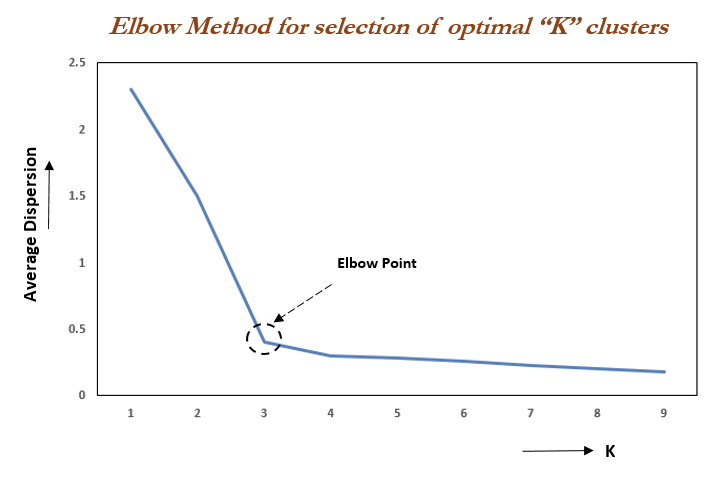

Intuitively, the Elbow Method can just be thought of as employing the logic of the Law of Diminishing Returns. That is, `k` should be chosen such that the corresponding inertia is relatively small, but larger values of `k` do not result in significantly better modeling of the data. The Elbow Method seeks to determine the optimum by avoiding both underfitting the data (choosing `k` with a large inertia) and overfitting the data (choosing `k` when `k - 1` has a comparable inertia).

For the inertia graph generated by running K-Means Clustering on this housing dataset, it would seem that the optimal value of `k` is 6. So let's run K-Means Clustering when `k == 6` and analyze the homogenity of the generated clusters.

In [ ]:
def convert_cluster_indexes_to_dfs(cluster_list_indexes, df):
    '''
    Takes `cluster_list_indexes`, which is a list of lists, where the ith list
    contains all of the data point indexes associated with the ith cluster, and
    returns a list of dataframes, where the ith dataframe is `df` but filtered
    to only have the rows associated with the ith cluster.
    
    :param cluster_list_indexes: The output of KMeansCluster.get_clusters_indexes()
    :param df: The df associated with the indexes provided by `cluster_list_indexes`.
    '''
    cluster_dfs = []
    for cluster in cluster_list_indexes:
        cluster_dfs.append(df.iloc[cluster, :])
    return cluster_dfs

model = KMeansCluster(6, debug=False)
model.load_points(df)
model.init_centroids()
model.train()
display_df = original_df.drop("zipcode", axis=1).drop("id", axis=1).drop("date", axis=1)
clusters_df_list = convert_cluster_indexes_to_dfs(model.get_clusters_indexes(), display_df)
print(clusters_df_list)

The above output is essentially uninterpretable. It's not clear at all what similarities the points in each cluster has.

To assist with interpreting the different clusters, the means and standard deviations for each relevant column in the dataset will be calculated.

In [ ]:
display_df = original_df.drop("zipcode", axis=1).drop("id", axis=1).drop("date", axis=1)

print(display_df.columns.to_list())
for i, cluster_df in enumerate(clusters_df_list):
    print("Cluster: {}".format(i))
    print("Means: {}".format([str(el)[:5] for el in cluster_df.mean().to_list()]))
    print("Standard Deviations: {}".format([str(el)[:5] for el in cluster_df.std().to_list()]))

It's still a bit challenging, from this information, to make out what differences are present between clusters, or even how homogenous each cluster is, although some observations can still be made. The clusters don't differ along some features - the mean `condition` and `bedrooms` of all clusters are comparable - but clusters are distinguishable through other features. The mean `sqft_living15`, `sqft_above`, `grade`, `sqft_living`, `floors`, `bathrooms`, and `price` of the first cluster are larger than those of every other cluster. But other clusters' means don't differ by much, and almost all of the standard deviations are relatively high, suggesting that clusters may be aribtary and not cohesive. But why is this?

Recall that K-Means Clustering works off of the assumption that similar data points will be close together in space, and that dissimilar points will be far apart. Proximity is determined using Euclidean distance (this sometimes changes, but most implementations of K-Means Clustering using this), but Euclidean distance has several shortcomings when applied to high-dimmensionality points. It suffers from the curse of dimensionality and is sensitive to noisy dimensions. Specifically, it suffers from a phenomenon where as the dimensionality of a dataset increases, the ratio between the Euclidean distance from any point to the furthest and closest point approaches 1. This fact may not be obvious at first, but note that as additional features are added to a dataset, some noisy features will be added as well. Thus, if infinite features are added, infinite noisy features would also be added, increasing the Euclidean distance between both similar and dissimilar points to infinity. 

With infinite data points this phenomenon would not occur, as there would be a point at every location in the infinite-dimensional space, so note that the above phenomenon is more prevalent in sparse datasets.

To illustrate how dimmensionality affects Euclidean distance, a quick graph of the maximum Euclidean distance between any two points across dimensionality will be generated.

In [ ]:
distances = []

for i in range(1, 101):
    distances.append(np.linalg.norm(np.zeros(i) - np.ones(i)))

plt.figure(figsize=(8, 8))
plt.plot([i+1 for i in range(len(distances))], distances)
plt.title("Features differ on all dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Max Euclidean Distance")
plt.grid()
plt.show()

This graph illustrates that the maximum Euclidean distance between any two points (when normalized between 0 and 1) is the square root of the dimensionality of the points. Thus, for example, 64 dimensions can be at most `sqrt(64) == 8` units apart.

In the case of one-hot encoded dimensions, however, the maximum Euclidean distance contributed by them could only ever be `sqrt(2) ~= 1.41`, even in the case of `zipcode`, which is mapped on to 70 dimensions when one-hot encoded. That's because for any given `zipcode` (or for any one-hot encoded variable), a given value will result in one of the encoded dimensions having a value of 1 while all other values have a dimension of 0. When `zipcode` values differ, they will still be the same across 68 of the 70 dimensions.

Note also the variable `waterfront`, which is a binary value that was transformed into a one-hot encoded variable. As a single dimension, the difference between a positive and negative `waterfront` will always have a Euclidean distance of 1 unit, but as a one-hot encoded variable, the difference will be `sqrt(2) ~= 1.41`. 

The consequences of the above is that two houses that only differ by `waterfront` will be treated as less similar than two houses that differ only by the number of bedrooms, but one has the smallest number of bedrooms and one has the largest number of bedrooms. Thus, differences in houses between `zipcode` and `waterfront` are weighted more than differences between houses among all other features. 

Besides this, all features are weighted the same, which by itself may also pose a significant issue. Whereas certain models like Random Forest may learn feature importance, K-Means Clustering treats all dimensions equally. Houses which differ only by their latitude are as different as houses which differ only by their price are as different as houses which differ only by their year built are as different as houses that differ by whether they were renovated or not. All features being weighted equally may be a desirable trait of an Unsupervised Learning model such as K-Means Clustering, but it's a trait which a user should be aware of regardless.

In an attempt to generate better clusters, the same models will be trained but on a dataset without any one-hot encoded features: `zipcode` will be removed from the dataset, and `waterfront` will be treated as a single dimension. Hopefully this will result in both lower inertias and more similarities between intra-cluster data points.

In [ ]:
df = original_df.copy()

# Drop the `id` and `zipcode` column
df = df.drop("id", axis=1)
df = df.drop("zipcode", axis=1)

# Format the `date` column
df["date"] = df["date"].apply(lambda date: date[:date.index("T")])
df["date"] = pd.to_datetime(df["date"]).astype(int)

# Convert all entries to float
df = df.astype(float)

# Min-Max Normalization
df = (df - df.min())/(df.max() - df.min())

inertias = []

print("Dimensionality: {}".format(len(df.columns)))

for k in range(1, max_k + 1):
    print("k == {}".format(k))
    model = KMeansCluster(k, debug=False)
    model.load_points(df)
    model.init_centroids()
    model.train()
    inertias.append(get_inertia(model.get_clusters(), model.centroids))

plt.figure(figsize=(8, 8))
plt.plot([i+1 for i in range(len(inertias))], inertias)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid()
plt.show()

Whereas the inertia of the original dataset representation using one-hot encoded variables when `k == 1` was `~35_000`, the inertia when `k == 1` after dropping `zipcode` and treating `waterfront` as a single dimension is only `~9500`. Given that inertia when `k == 1` represents the sum of the squared distances of the dataset to the mean, this is a significant difference considering that only one feature was removed between the two representations.

Additionally, the above inertia graph forms a more clear elbow than the previous inertia graph, with `k == 5` having an inertia of `~5000`, `k == 10` having an inertia of `~4000`, and `k == 50` having an inertia of `~2000`. 

Recall that for the original inertia graph, the value of inertia dropped by `~9000` from `k == 1` to `k == 10`, whereas the inertia dropped by `~4500` over the same `k` values above. While the inertia value did not change as much for the above graph in value, note that the inertia of the above graph dropped to `~40%` of its original value while the inertia of the original graph dropped to only `~75%` of its original value. Thus, the clusters formed on the dataset without one-hot encodings is able to form tighter clusters than the dataset with one-hot encoding when `k == 10`, and this trend tends to hold for almost all values of `k`.

But it's unclear just from the inertia graph whether the means and standard deviations obtained from the generated clusters will be easier to interpret than before. To determine this, the means and standard deviations of the clusters when `k == 8` will be analyzed, with `k` being set to 8 as it appears to be the elbow of the inertia graph.

In [ ]:
model = KMeansCluster(8, debug=False)
model.load_points(df)
model.init_centroids()
model.train()
display_df = original_df.drop("zipcode", axis=1).drop("id", axis=1)
display_df["date"] = display_df["date"].apply(lambda date: date[:date.index("T")])
display_df["date"] = pd.to_datetime(display_df["date"]).astype(int)
display_df["date"] = display_df["date"].max() - display_df["date"]
display_df = display_df.astype(float)
clusters_df_list = convert_cluster_indexes_to_dfs(model.get_clusters_indexes(), display_df)

print(display_df.columns.to_list())
for i, cluster_df in enumerate(clusters_df_list):
    print("Cluster: {}".format(i))
    print("Means: {}".format([str(el)[:8] for el in cluster_df.mean().to_list()]))
    print("Standard Deviations: {}".format([str(el)[:8] for el in cluster_df.std().to_list()]))

There do seem to be some more obvious trends here - one cluster has a relatively large mean waterfront value of, while all of the other clusters have a mean waterfront value of `~0.0` - but the representation of the data as text is somewhat hard to interpret. The above data will be displayed as bar graphs for each feature, with the overall means over the entire dataset of each feature of the entire dataset displayed as well for convenience.

In [ ]:
for feature in display_df.columns.to_list():
    means = [cluster_df[feature].mean() for cluster_df in clusters_df_list]
    stds = [cluster_df[feature].std() for cluster_df in clusters_df_list]
    plt.bar([i for i in range(len(stds))], means, yerr=stds, ecolor="black", error_kw=dict(capsize=10, capthick=4))
    plt.bar([len(clusters_df_list)], [display_df[feature].mean()], yerr=display_df[feature].std(), error_kw=dict(capsize=10, capthick=4), ecolor="black", color="red")
    plt.title("Feature: " + feature)
    plt.xlabel("Cluster Number (Red is total dataset)".format(len(clusters_df_list)))
    plt.ylabel("Means")
    plt.ylim(min([mean - std for mean, std in zip(means, stds)]), max([mean + std for mean, std in zip(means, stds)]))
    plt.grid()
    plt.show()

In the above bar graphs, the `n`th cluster is assigned the `n`th bar, with the overall dataset's means and standard deviations being assigned the rightmost, red bar. The standard deviations are shown using error bars, with the minimum and maximum y value of each graph being equal to the lowest and highest error bar, respectively, so as to help show contrast between the values of features for different clusters.

The bar graphs do illustrate some differences among clusters. One cluster, for example, had a significantly higher mean `view` than all of the other clusters - this cluster also happened to have to the largest mean `waterfront` and `price`, which matches intuition - a house on the water is likely to have a good view, and is likely to be expensive as well. Another cluster had a significantly higher mean `yr_renovated` than all of the other clusters. Intriguingly, this cluster had the second highest mean `view`, `waterfront`, and `price` values, potentially suggesting that houses on the water are more likely to be renovated (though this should not be the conclusion of the data).

Some of the other clusters don't have as obvious differences from their peers, or have means that have differences in means that are well within the standard deviatons of each other. Two clusters in particular seem to differ significantly only in their mean `date` values, with all other mean values being effectively the same. If these clusters differ in means only along one feature, why are they distinct instead of combined? Would `k == 7` be a better value for this dataset, or do these results suggest that trying to form clusters from a housing prices dataset is ill-advised?

Once more, feature selection will be performed on the dataset, but this time a significant number of the features will be discarded in an attempt to see how cohesive the clusters when trained only on a few dimensions. Specifically, the above steps will be conducted but on the dataset with only the `price`, `bedrooms`, `bathrooms`, `floors`, and `waterfront` features.

In [ ]:
df = original_df.copy()[["price", "bedrooms", "bathrooms", "floors", "waterfront"]].astype(float)

# Min-Max Normalization
df = (df - df.min())/(df.max() - df.min())

inertias = []
for k in range(1, max_k):
    print("k == {}".format(k))
    model = KMeansCluster(k, debug=False)
    model.load_points(df)
    model.init_centroids()
    if not model.train():
        break
    inertias.append(get_inertia(model.get_clusters(), model.centroids))
    
plt.figure(figsize=(8, 8))
plt.plot([i+1 for i in range(len(inertias))], inertias)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid()
plt.show()

Using the elbow method once more, `k == 5` appears to be an appropriate value to use for `k`, as it has `inertia ~== 225` so it will be evaluated below.

In [ ]:
model = KMeansCluster(5, debug=False)
model.load_points(df)
model.init_centroids()
model.train()
display_df = original_df[["price", "bedrooms", "bathrooms", "floors", "waterfront"]]
display_df = display_df.astype(float)
clusters_df_list = convert_cluster_indexes_to_dfs(model.get_clusters_indexes(), display_df)

for feature in display_df.columns.to_list():
    means = [cluster_df[feature].mean() for cluster_df in clusters_df_list]
    stds = [cluster_df[feature].std() for cluster_df in clusters_df_list]
    plt.bar([i for i in range(len(stds))], means, yerr=stds, ecolor="black", error_kw=dict(capsize=10, capthick=4))
    plt.bar([len(clusters_df_list)], [display_df[feature].mean()], yerr=display_df[feature].std(), error_kw=dict(capsize=10, capthick=4), ecolor="black", color="red")
    plt.title("Feature: " + feature)
    plt.xlabel("Cluster Number (Red is total dataset)".format(len(clusters_df_list)))
    plt.ylabel("Means")
    plt.ylim(min([mean - std for mean, std in zip(means, stds)]), max([mean + std for mean, std in zip(means, stds)]))
    plt.grid()
    plt.show()

According to the output of the model, the sizes of the clusters are `[8937, 6554, 4069, 163, 1890]`.

The smallest cluster, `3`, is unique in that it seems to contain all of the houses with a waterfront view, and potentially as a result of this has a signficiantly higher mean `price` than any of the other clusters. Clusters `0` and `1` have similar means across all categories except for `floors`, where the mean floor of cluster `0` is ~2.0, while the mean floor of cluster `1` is ~1.0. Cluster `2` has a significantly lower mean `bedrooms` and `bathrooms` than the other clusters, and cluster `4` has a mean `floors` of ~1.5, separating it from the other clusters.

The means and standard deviations of the above clusters are different enough such that it's relatively straightforward what cluster a novel data point would be assigned to, so from that perspective these clusters are more distinct than those formed when the dimensionality of the dataset was 19 earlier. So these results might serve as a logical conclusion for this notebook.

But it should be noted that the clusters formed when `k == 5` above are _slightly_ different than those formed when `k == 5` before. That is, the sizes of the clusters now are `[8937, 6554, 4069, 163, 1890]`, but originally, with the same feature set, they were `[6568, 772, 163, 8653, 5457]`.

These differing results are a consequence of using the Forgy method to initialize the centroid, as the final locations of the centroids are dependent on what their starting locations were. Thus, the resulting clusters are a function of the initial locations of the centroids, so clusters are liable to change with each run of the K-Means Clustering algorithm.

How should this principle be interpreted, though? Will clusters calcualted by K-Means Clustering (with Forgy initialization) be vastly different with each run? If so, one could reach the conclusion that Forgy intialization wouldn't be nearly as popular as it is, so how different can clusters be expected to be between each execution of the algorithm?

To get some insight into this, K-Means Clustering will be run 25 times with `k == 5` for the above dataset.

In [ ]:
inertias = []

for i in range(25):
    print("Iteration: {}".format(i))
    model = KMeansCluster(5, debug=False)
    model.load_points(df)
    model.init_centroids()
    if not model.train():
        break
    inertias.append(get_inertia(model.get_clusters(), model.centroids))
    
plt.figure(figsize=(8, 8))
plt.plot([i+1 for i in range(len(inertias))], inertias)
plt.title("k == 5")
plt.xlabel("Iteration")
plt.ylabel("Inertia")
plt.grid()
plt.show()
print("Mean inertia: {}".format(np.mean(inertias)))

Before analyzing the above results, recall that when the inertias were originally calculated for the housing dataset with only five of the features used (`["price", "bedrooms", "bathrooms", "floors", "waterfront"]`), the inertia was ~420 when `k == 4`, ~225 when `k == 5`, ~300 when `k == 6`, and ~250 when `k == 7`. 

The above results suggest that the original inertia of ~225 was at the lower end of the possible permutations of `k == 5` clusters. Of the 25 iterations, only 5 had an inertia below 250, while 7 had an inertia above 350, meaning that the remaining 13 iterations had inertia values between 250 and 350.

The mean inertia when `k == 5` for these results, ~300, is greater than the inertia when `k == 6` and `k == 7`, but that doesn't necessarily indicate that `5` is a bad value for `k`, but that the clusters obtained when `k == 5` were, by chance, better than average for `k == 5`.

In the 25 iterations above, there are no egregious outliers, but the results do provide evidence that a single run of K-Means Clustering may produce misleading results. Furthermore, these results illustrate why it is common practice to run K-Means Clustering several times _after_ picking the best value for `k`  with the elbow method, so as to obtain the best arrangement of clusters foor the best value of `k`.

It should be noted that it can be worthwhile to run K-Means Clustering several times for each value of `k` and then use the means of those results to plot the inertias and determine the "elbow" of the graph, but this is a trade-off between time and resources and less noisy results that people often opt out of doing.

Of course, these observations are only from a single, heavily preprocessed dataset. It's not at all obvious how generalizable these trends are, or if similar patterns will be found in dissimilar datasets. It's not at all safe to conclude that because the variance of inertias for a single value of `k` for a single dataset were as shown above, that similar patterns can be expected in other datasets.

So, to try to produce simmilar results in a disparate dataset, a mock dataset will be constructed below.

In [ ]:
class MockCluster:
    def __init__(self, center, r, n):
        '''
        A mock cluster, which generates `n` points distributed uniformly
        in a circle of radius  `r` around the two-dimensional point `center`.
        
        :param center: A two-dimensional tuple representing the center of the cluster.
        :param r: The radius of the cluster. No generated points will be beyond `r`.
        :param n: The number of points to generate in the cluster.
        '''
        self.center = center
        self.r = r
        self.n = n
        theta = rs.uniform(0, np.pi * 2, self.n)
        radius = np.sqrt(rs.uniform(0, self.r, self.n))
        self.points = np.array((self.center[0] + (radius * np.cos(theta)), self.center[1] + (radius * np.sin(theta)))).T
    
    def plot(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.points[:, 0], self.points[:, 1])
        plt.grid()
        plt.show()
        
        
class MockClusters:
    def __init__(self, clusters):
        '''
        Contains a group of MockClusters for convenience.
        
        :param clusters: A list of MockClusters
        '''
        self.clusters = clusters
        self.points = self.clusters[0].points
        for cluster in self.clusters[1:]:
            self.points = np.concatenate((self.points, cluster.points))
        
    
    def plot(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.points[:, 0], self.points[:, 1])
        plt.grid()
        plt.show()
        
    def df(self):
        '''
        Returns all of the points in all of the clusters as a dataframe with two columns
        for the two dimensions.
        '''
        return pd.DataFrame(self.points, columns=["x", "y"])
    
    def kmeans(self, k):
        '''
        Runs a KMeansCluster on the collection of clusters and plots all of the points
        in the dataset along with the calculated centroids after running the algorithm.
        '''
        model = KMeansCluster(k, debug=False)
        model.load_points(self.df())
        model.init_centroids()
        model.train()
        
        plt.figure(figsize=(6, 6))
        plt.scatter(self.points[:, 0], self.points[:, 1])
        plt.scatter(model.get_centroids()[:, 0], model.get_centroids()[:, 1], color="red")
        plt.grid()
        plt.show()
        print("Intertia: {}".format(get_inertia(model.get_clusters(), model.get_centroids())))
        
        

clusters = MockClusters([MockCluster((2, 5), 5, 2500), MockCluster((0, 0), 2, 100), MockCluster((4, 0), 8, 25)])
clusters.kmeans(3)
print("Ideal inertia: {}".format(get_inertia([cluster.points for cluster in clusters.clusters], [(2, 5), (0, 0), (4, 0)])))



For the above data, the ideal location for the centroids is `(2, 5)`, `(0, 0)`, and `(4, 0)`,  and a human giving a cursory glance at the above graph would likely place the three centroids at those locations. However, after running the K-Means Clusters algorithm, the centroids are instead located at approximately `(1.5, 3.0)`, `(1.0, 5.5)`, and `(3.0, 5.0)`.

Additionally, the inertia of the clusters generated using K-Means Clustering is ~4350, while the "ideal" inertia that is obtained from placing the centroids at their "proper" locations is ~6300.

So, clearly, K-Means Clustering can sometimes be "wrong". But how should these results be interpreted? 

First, while inertia is a popular criteria used for forming clusters in K-Means Clustering, there are other alternatives that may lead to better results depending on the dataset. Second, the resulting clusters obtained from running K-Means Clustering can vary greatly depending on the initial location of the centroids, and as a result the Forgy Method for initialization isn't always an ideal choice. Lastly, and while this may be obvious, K-Means Clustering has no clear metric for determining how good the resulting clusters it generates are. While supervised learning algorithms can generally be assessed using accuracy, F1 Scores, or additional metrics, only metrics like inertia and distortion can be used to assess the results of K-Means Clustering. And, as the results above show, sometimes these metrics can be misleading, and when working with high-dimensionality data, it's not as easy for a human to assess the reliability of the results as it is when looking at the graph of the two-dimensional dataset above.

In conclusion, it doesn't seem that K-Means Clustering reveals any surprising trends in the housing dataset other than further showing that qualities like `view`, `waterfront`, and `price` are highly correlated with each other. However, this dataset being ill-suited for K-Means Clustering does help to show some of the common pitfalls associated with the algorithm and how they can be avoided.